In [2]:
#import the necessary libraries
import os
import cv2 as cv
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model, layers, Sequential, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers, Model

In [3]:
#load the train and test data
train_dir='/content/drive/MyDrive/research_pro/own/train'
test_dir='/content/drive/MyDrive/research_pro/own/test'

In [4]:
#initializing empty lists to store an array of images
Size=224
X_test=[]
y_test=[]

In [5]:
#Augmentation
import tensorflow as tf
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1/255.0,
).flow_from_directory(train_dir,batch_size=16,target_size=(Size,Size),subset="training",shuffle=True)

Found 197 images belonging to 2 classes.


In [6]:
#Loading testing data
valid_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
).flow_from_directory(test_dir,batch_size=16,target_size=(Size,Size),shuffle=False)

Found 36 images belonging to 2 classes.


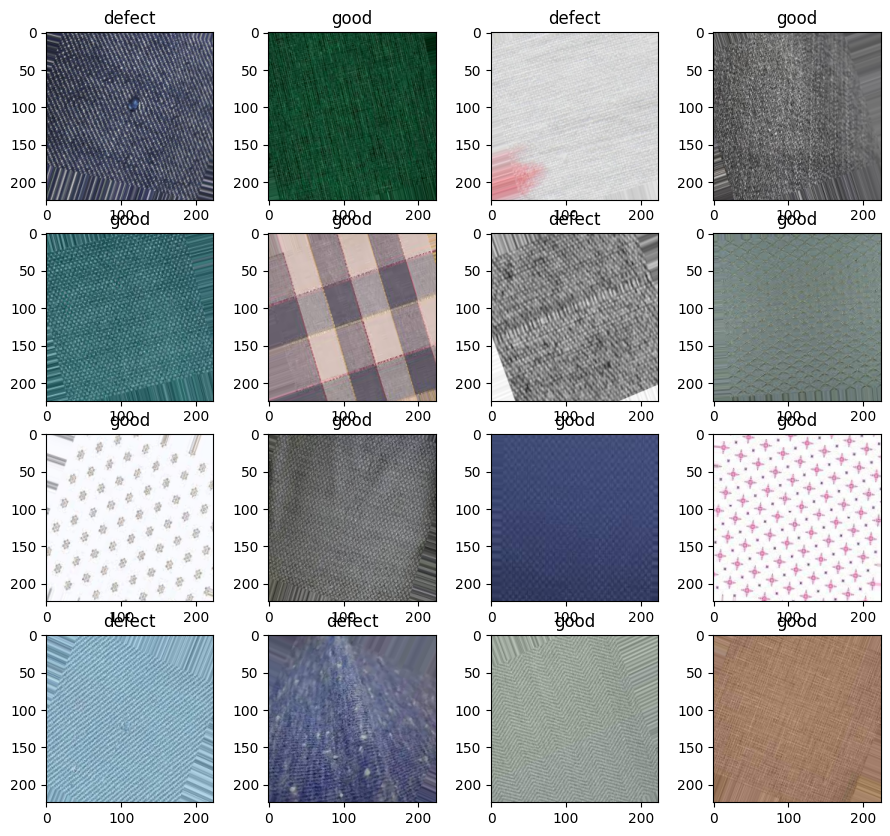

In [7]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(11,10))
for X_batch, y_batch in train_generator:

    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break


In [8]:
print(classes)

['defect', 'good']


In [11]:
#InceptionV3
inception_model = InceptionV3(input_shape= (Size, Size, 3),
                                include_top = False,
                                weights = "imagenet")#pretrained weights trained on the ImageNet dataset will be used

In [13]:
for layer in inception_model.layers:
    layer.trainable = False #When trainable is set to False, it means that the weights of the layer will not be updated during training

In [16]:
last_layer = inception_model.get_layer('mixed9')#last convolutional layer before the fully connected layers #mixed9-useful for various purposes such as feature extraction, visualization, or modifying the model architecture.
print('Last Layer Output Shape:', last_layer.output_shape)#prints the output shape of the last layer.
last_output = last_layer.output

x = layers.Flatten()(last_output)#flattens the output tensor of the last convolutional layer, converting it into a 1D tensor.

x = layers.Dense(2048, activation='relu')(x)#adds a fully connected (dense) layer with 2048 units and ReLU activation function.

x = layers.Dense(1024, activation='relu')(x)#adds another fully connected layer with 1024 units and ReLU activation function.;2 dense layers coz-to learn complex, nonlinear mappings between the extracted features and the target classes.

x = layers.Dropout(0.2)(x)# a regularization technique used to prevent overfitting by randomly dropping a fraction of input units during training.

x = layers.Dense(2, activation='sigmoid')(x)#adds the final output layer with 2 units (assuming it's a binary classification task) and a sigmoid activation function, which outputs probabilities for the two classes.

inception3 = Model(inception_model.input, x)#creates a new model (inception3),input tensor is the input of the InceptionV3 model,output tensor is the output of the custom classification layers


Last Layer Output Shape: (None, 5, 5, 2048)


In [17]:
inception3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])#configures the training process for the model, specifying the optimizer, loss function, and evaluation metrics.

In [18]:
history=inception3.fit(train_generator,validation_data=valid_generator,steps_per_epoch=5,epochs=10,batch_size=32)

Epoch 1/10
5/5 [==============================] - 47s 8s/step - loss: 2.4696 - accuracy: 0.5362 - val_loss: 0.6501 - val_accuracy: 0.8056
Epoch 2/10
5/5 [==============================] - 27s 5s/step - loss: 0.9380 - accuracy: 0.7875 - val_loss: 0.2864 - val_accuracy: 0.9167
Epoch 3/10
5/5 [==============================] - 24s 5s/step - loss: 0.7013 - accuracy: 0.7971 - val_loss: 0.1994 - val_accuracy: 0.9722
Epoch 4/10
5/5 [==============================] - 26s 5s/step - loss: 0.3107 - accuracy: 0.9125 - val_loss: 0.4396 - val_accuracy: 0.9167
Epoch 5/10
5/5 [==============================] - 25s 5s/step - loss: 0.5179 - accuracy: 0.8696 - val_loss: 0.0884 - val_accuracy: 0.9722
Epoch 6/10
5/5 [==============================] - 25s 5s/step - loss: 0.1628 - accuracy: 0.9420 - val_loss: 0.1884 - val_accuracy: 0.9167
Epoch 7/10
5/5 [==============================] - 27s 6s/step - loss: 0.2276 - accuracy: 0.9000 - val_loss: 0.1962 - val_accuracy: 0.8889
Epoch 8/10
5/5 [==================

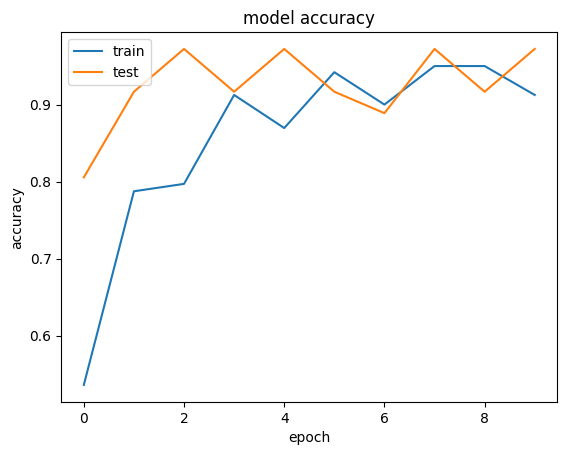

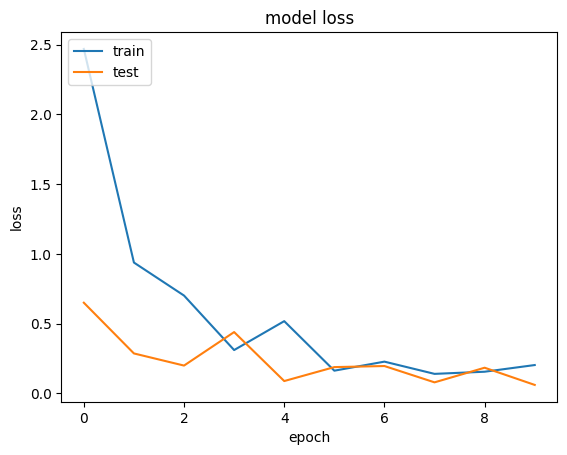

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

1/1 [==============================] - 0s 176ms/step
Predicted Class: good fabric


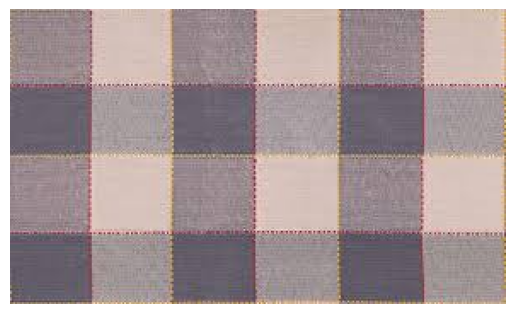

In [28]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img_path = '/content/drive/MyDrive/research_pro/own/test/good/gf53.jpeg'
img_width, img_height = 224, 224
img = image.load_img(img_path, target_size=(img_width, img_height))

# Convert image to array and preprocess it
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make predictions
prediction = inception3.predict(img_array)

# Extract the predicted probability
predicted_prob = prediction[0][0]

# Convert predicted probability to class label
class_label = "defective fabric" if predicted_prob >= 0.5 else "good fabric"

print("Predicted Class:", class_label)

# Display the image
imgg = mpimg.imread(img_path)
plt.imshow(imgg)
plt.axis('off')
plt.show()
